In [1]:
from sklearn.utils import shuffle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,KFold
from tqdm import tqdm
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")


# 读入新的train和test数据

In [2]:
train = pd.read_csv('train.csv') 
target = pd.read_csv('train_target.csv')
train['target'] = target['target']

test = pd.read_csv('test.csv')

In [3]:
# isNew　＝　1和ｉｓＮｅｗ　＝　０的　residentAddr　编码方式不同,将数据分为新数据和旧数据
train.loc[train['isNew'] ==0,'residentAddr'] = train[train['isNew'] ==0]['residentAddr'].apply(lambda x: x if x == -999 else x-300000)
train.loc[train['residentAddr']==-300999,'residentAddr'] = -999

train1 = train[train['isNew'] == 0].reset_index(drop=True)
train2 = train[train['isNew'] == 1].reset_index(drop=True)

In [4]:
train = pd.concat([train1,train2],sort= False)
# 两种方式构造ｔｒａｉｎ
# train = train2

In [5]:
train1.shape

(84196, 105)

In [6]:
train2.shape

(47833, 105)

In [7]:
data_train_test_all = train.append(test).reset_index(drop=True)

In [8]:
data_train_test_all.shape

(155590, 105)

In [9]:
# 定义一些辅助函数
def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    return train_df, test_df
        
# LABEL ENCODE
def encode_LE(col,train = train,test = test,verbose=True):
    data = pd.concat([train,test],sort = False)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(data[col].values))
    data[col] = lbl.transform(list(data[col].values))
    train = data[0:len(train)]
    test = data[len(train):]
    return train,test


def encode_AG(main_columns, uids, aggregations=['mean'], train_df=train, test_df=test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
    return train_df,test_df
                
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=train, test_df=test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')
            
    return train_df,test_df


def get_time(train):
    train['dt_bg'] = train.certValidBegin-2208988800
    train['dt_bg'] = pd.to_datetime(train['dt_bg'] * 1000000000)
    train['dt_year'] = train.dt_bg.dt.year
    train['dt_month'] = train.dt_bg.dt.year*100+train.dt_bg.dt.month
    train['bk_time'] = (train['age']*365*24*3600+ train.certValidBegin-data_train_test_all.certValidBegin.max())/365/24/3600
    del train['dt_bg']
    return train

In [10]:
# highestEdu进行编码
train['highestEdu'] = train['edu'].astype(str)+'_'+train['highestEdu'].astype(str)
test['highestEdu'] = test['edu'].astype(str)+'_'+test['highestEdu'].astype(str)
train,test = encode_LE(['highestEdu'],train = train,test = test,verbose=True)

# 唯一身份编码
train['uid'] = train['certId'].astype(str)+'_'+train['gender'].astype(str)+'_'+train['ethnic'].astype(str)+'_'+train['dist'].astype(str)
test['uid'] = test['certId'].astype(str)+'_'+test['gender'].astype(str)+'_'+test['ethnic'].astype(str)+'_'+test['dist'].astype(str)
train,test = encode_LE(['uid'],train = train,test = test,verbose=True)

# 预授权金额和基础评级
train['lmt_basicLevel'] = train['lmt'].astype(str)+'_'+train['basicLevel'].astype(str)
test['lmt_basicLevel'] = test['lmt'].astype(str)+'_'+test['basicLevel'].astype(str)
train,test = encode_LE(['lmt_basicLevel'],train = train,test = test,verbose=True)

# 年龄和联系人关系
train['age_linkRela'] = train['age'].astype(str)+'_'+train['linkRela'].astype(str)
test['age_linkRela'] = test['age'].astype(str)+'_'+test['linkRela'].astype(str)
train,test = encode_LE(['age_linkRela'],train = train,test = test,verbose=True)

# gender和联系人关系
train['gender_linkRela'] = train['gender'].astype(str)+'_'+train['linkRela'].astype(str)
test['gender_linkRela'] = test['gender'].astype(str)+'_'+test['linkRela'].astype(str)
train,test = encode_LE(['gender_linkRela'],train = train,test = test,verbose=True)

#  性别和产品类型
train['gender_loanProduct'] = train['gender'].astype(str)+'_'+train['loanProduct'].astype(str)
test['gender_loanProduct'] = test['gender'].astype(str)+'_'+test['loanProduct'].astype(str)
train,test = encode_LE(['gender_loanProduct'],train = train,test = test,verbose=True)

#  性别和job
train['gender_job'] = train['gender'].astype(str)+'_'+train['job'].astype(str)
test['gender_job'] = test['gender'].astype(str)+'_'+test['job'].astype(str)
train,test = encode_LE(['gender_job'],train = train,test = test,verbose=True)

#  年龄和产品类型
train['age_loanProduct'] = train['age'].astype(str)+'_'+train['loanProduct'].astype(str)
test['age_loanProduct'] = test['age'].astype(str)+'_'+test['loanProduct'].astype(str)
train,test = encode_LE(['age_loanProduct'],train = train,test = test,verbose=True)

#  time
train['age_loanProduct'] = train['age'].astype(str)+'_'+train['loanProduct'].astype(str)
test['age_loanProduct'] = test['age'].astype(str)+'_'+test['loanProduct'].astype(str)
train,test = encode_LE(['age_loanProduct'],train = train,test = test,verbose=True)

train['x_33_x_34'] = train['x_33'].astype(str)+'_'+train['x_34'].astype(str)
test['x_33_x_34'] = test['x_33'].astype(str)+'_'+test['x_34'].astype(str)
train,test = encode_LE(['x_33_x_34'],train = train,test = test,verbose=True)

train['x_33_x_68'] = train['x_33'].astype(str)+'_'+train['x_68'].astype(str)
test['x_33_x_68'] = test['x_33'].astype(str)+'_'+test['x_68'].astype(str)
train,test = encode_LE(['x_33_x_68'],train = train,test = test,verbose=True)

train['x_34_x_75'] = train['x_34'].astype(str)+'_'+train['x_75'].astype(str)
test['x_34_x_75'] = test['x_34'].astype(str)+'_'+test['x_75'].astype(str)
train,test = encode_LE(['x_34_x_75'],train = train,test = test,verbose=True)

train['x_67_x_68'] = train['x_67'].astype(str)+'_'+train['x_68'].astype(str)
test['x_67_x_68'] = test['x_67'].astype(str)+'_'+test['x_68'].astype(str)
train,test = encode_LE(['x_67_x_68'],train = train,test = test,verbose=True)


train1['bankCard1'] = train1['bankCard'].apply(lambda x: str(x)[:6]).astype(float)
train1['dist_res'] = train1['dist']/data_train_test_all['residentAddr']
train1['certId_res'] = train1['certId']/data_train_test_all['residentAddr']
train1['dist1'] = train1['dist'].apply(lambda x: str(x)[:2]).astype(float)
train1['dist2'] = train1['dist'].apply(lambda x: str(x)[:3]).astype(float)
train1['residentAddr1'] = train1['residentAddr'].apply(lambda x: str(x)[:2]).astype(float)
train1['residentAddr2'] = train1['residentAddr'].apply(lambda x: str(x)[:3]).astype(float)


In [11]:
data_train_test_all['certTime'] = data_train_test_all.certValidStop - data_train_test_all.certValidBegin
data_train_test_all['week_hour'] = data_train_test_all['weekday']*100+data_train_test_all['setupHour']
data_train_test_all = get_time(data_train_test_all)  
train1 = get_time(train1)  

In [12]:
feas_x = ['x_{}'.format(i) for i in range(79)]+['ncloseCreditCard','unpayIndvLoan',
                                                'unpayOtherLoan','unpayNormalLoan',
                                                '5yearBadloan']

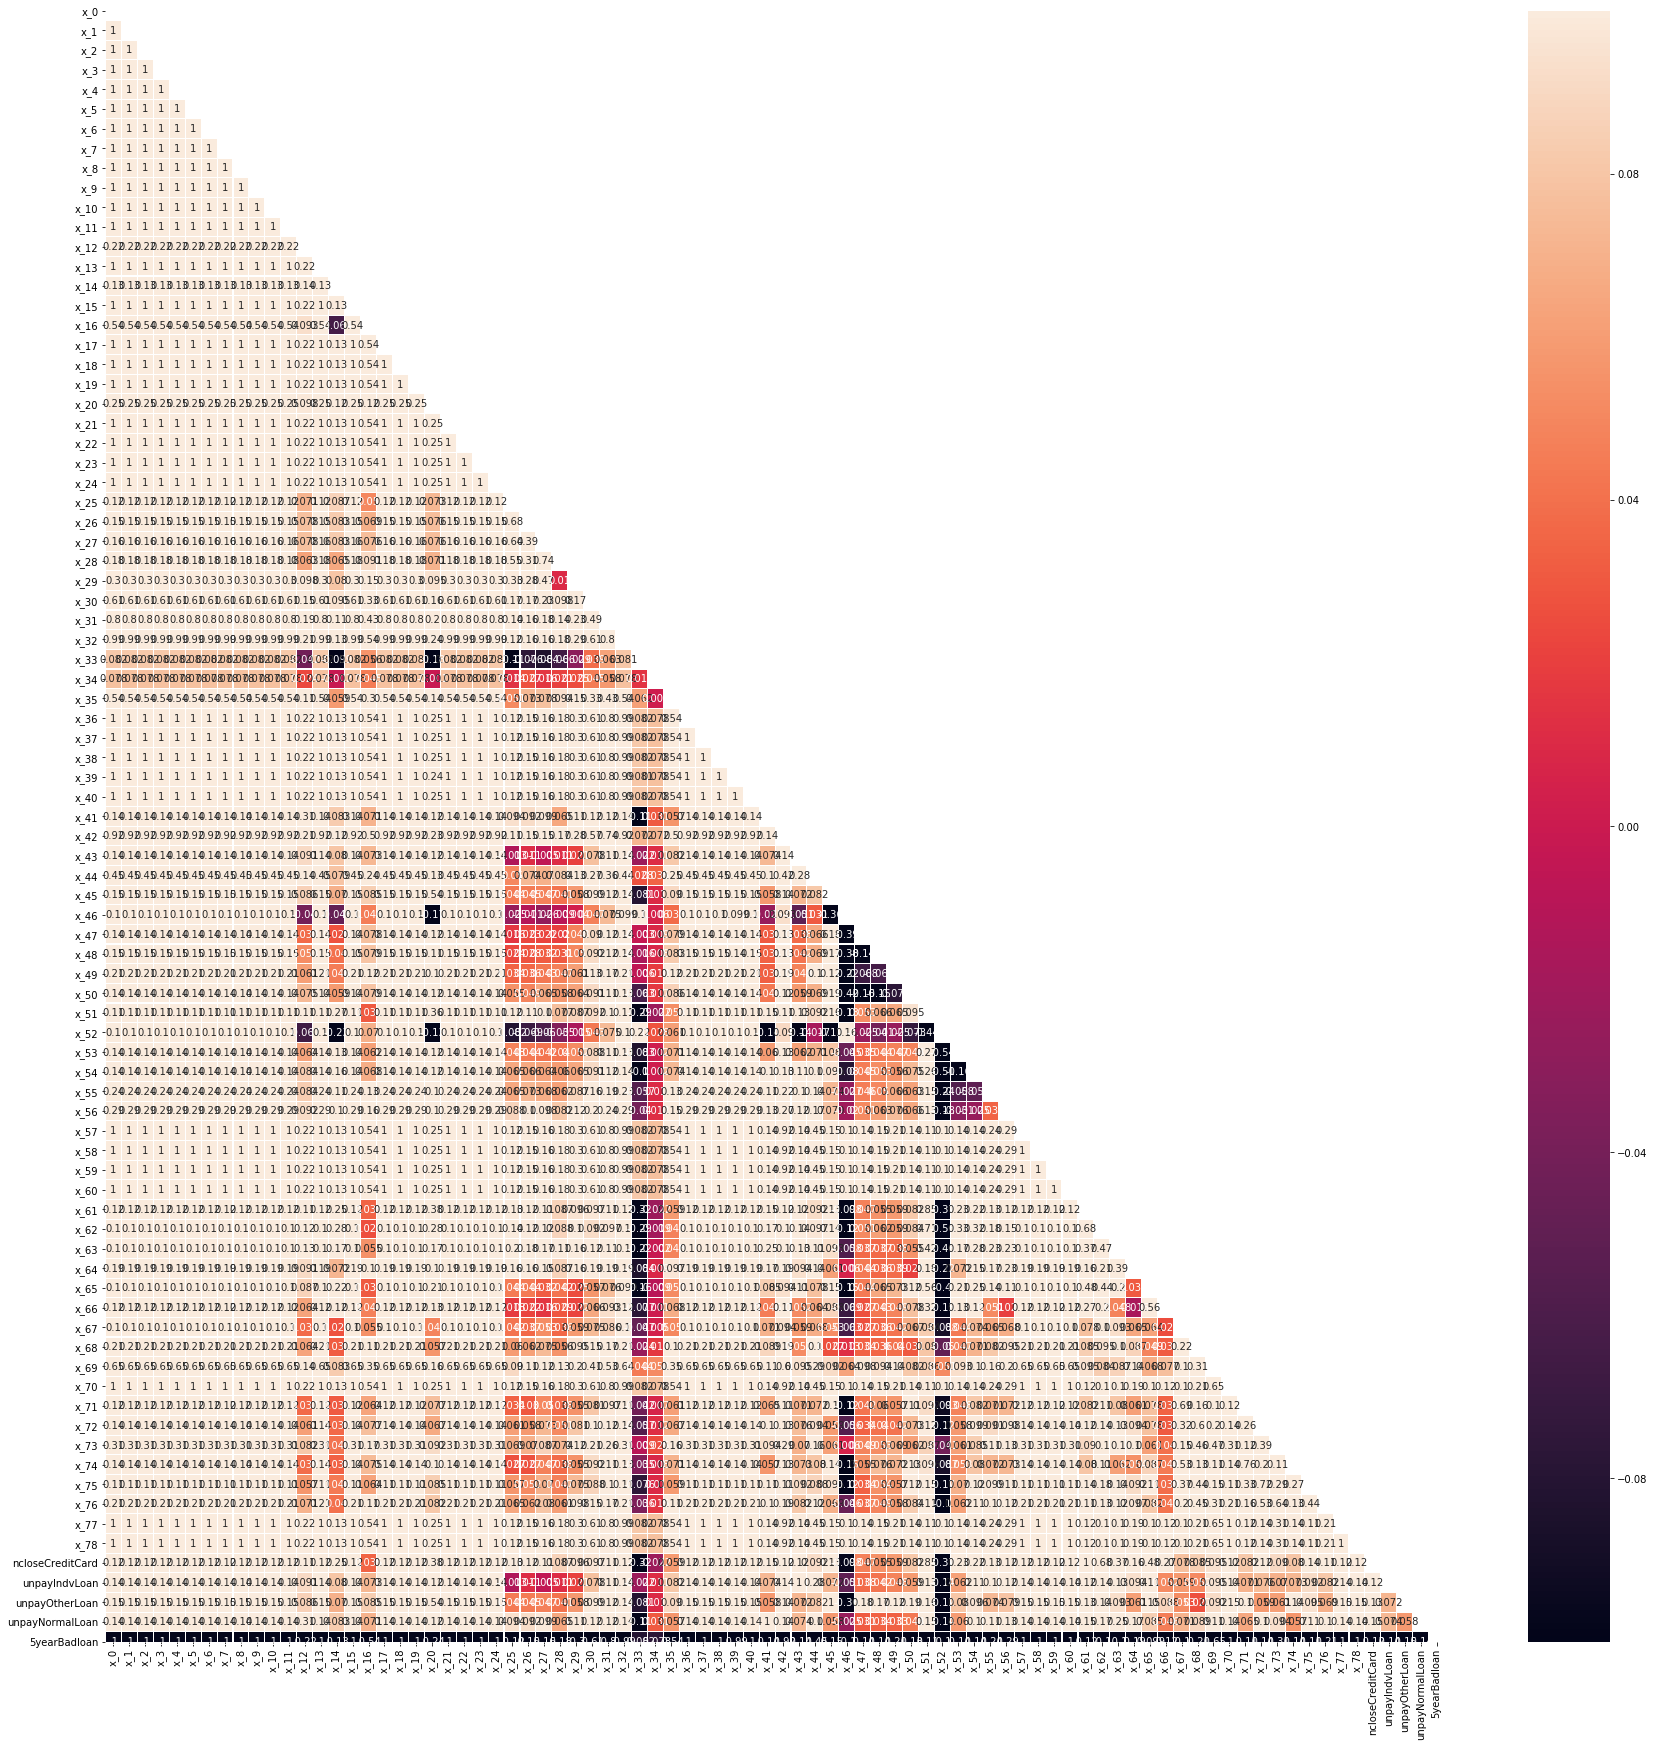

In [13]:
plt.figure(figsize=(30,30))
correlation = data_train_test_all[feas_x].corr('kendall')
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=correlation.round(3),mask=mask,vmin=-0.1,vmax=0.1,annot=True, linewidths=.1)

In [14]:

corr_fea = []
for i in tqdm(feas_x):
    corr_1_with = correlation[correlation[i]==1].index.tolist()
    corr_1_with.remove(i)
    corr_fea = corr_fea+corr_1_with
    
    
corr_fea = set(corr_fea)


for i in corr_fea:
    feas_x.remove(i)

100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 777.70it/s]


In [15]:
len(feas_x)

46

In [16]:
# 用晒选下来的ｂ特征，围绕ｌｍｔ和几个比较特别的特征做一些特征
for i in tqdm(feas_x):
    data_train_test_all[i+'wk_cnt'] = data_train_test_all.groupby(['weekday',i])[i].transform('count')
    data_train_test_all[i+'hour_cnt'] = data_train_test_all.groupby(['setupHour',i])[i].transform('count')
#     data_train_test_all[i+'basicLevel_cnt'] = data_train_test_all.groupby(['basicLevel',i])[i].transform('count')
#     data_train_test_all[i+'job_cnt'] = data_train_test_all.groupby(['job',i])[i].transform('count')
    
    data_train_test_all[i+'lmt_mean'] = data_train_test_all.groupby([i])['lmt'].transform('mean')
    data_train_test_all[i+'lmt_max'] = data_train_test_all.groupby([i])['lmt'].transform('max')
    data_train_test_all[i+'lmt_min'] = data_train_test_all.groupby([i])['lmt'].transform('min')
    data_train_test_all[i+'lmt_std'] = data_train_test_all.groupby([i])['lmt'].transform('std')
    

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [01:22<00:00,  1.79s/it]


In [17]:
cat_features_1 = ['dt_year','dt_month','job',
                'basicLevel','ethnic','highestEdu',
                'dist','gender','age','loanProduct', 
                'lmt','bankCard', 'residentAddr', 
                'linkRela','setupHour', 'weekday']
for i in tqdm(cat_features_1):
    data_train_test_all[i+'_count1'] = data_train_test_all.groupby([i])[i].transform('count')
    tmp = train1.groupby(i,as_index=False)['target'].agg({i+'_count2':'count',i+'_sum2':'sum'})
    data_train_test_all =data_train_test_all.merge(tmp,how='left')
    data_train_test_all[i+'_count2'] = data_train_test_all[i+'_count1'] /(data_train_test_all[i+'_count2'] +3)

    
    
    
cat_features_2 = ['dt_year','dt_month','job',
                'basicLevel','ethnic','highestEdu',
                'dist','gender','age','loanProduct', 
                'lmt','bankCard', 'residentAddr', 
                'linkRela','setupHour']
for i in tqdm(cat_features_2):
    data_train_test_all[i+'weekday_count'] = data_train_test_all.groupby(['weekday',i])[i].transform('count')
    

    
    
cat_features_3 = ['dt_year','dt_month','job',
                'basicLevel','ethnic','highestEdu',
                'dist','gender','age',
                'lmt','bankCard', 'residentAddr', 
                'linkRela','setupHour', 'weekday']
for i in tqdm(cat_features_3):
    data_train_test_all[i+'loanProduct_count'] = data_train_test_all.groupby(['loanProduct',i])[i].transform('count')
    tmp = train1.groupby(['loanProduct',i],as_index=False)['target'].agg({i+'loanProduct_count1':'count',i+'loanProduct_mn1':'mean'})
    data_train_test_all =data_train_test_all.merge(tmp,how='left')
    data_train_test_all[i+'loanProduct_count1'] = data_train_test_all[i+'loanProduct_count'] /(data_train_test_all[i+'loanProduct_count1'] +3)
    del data_train_test_all[i+'loanProduct_count']
    
    
cat_features_4 = ['dt_year','dt_month','job',
                'basicLevel','ethnic','highestEdu',
                'dist','gender','age','loanProduct', 
                'lmt','bankCard', 
                'linkRela','setupHour', 'weekday']
for i in tqdm(cat_features_4):
    data_train_test_all[i+'residentAddr_count'] = data_train_test_all.groupby(['residentAddr',i])[i].transform('count')
    tmp = train1.groupby(['residentAddr',i],as_index=False)['target'].agg({i+'residentAddr_count1':'count'})
    data_train_test_all =data_train_test_all.merge(tmp,how='left')
    data_train_test_all[i+'residentAddr_count1'] = data_train_test_all[i+'residentAddr_count'] /(data_train_test_all[i+'residentAddr_count1'] +3)
    del data_train_test_all[i+'residentAddr_count']        

100%|██████████| 15/15 [01:46<00:00,  7.14s/it]


In [ ]:
unique_col = ['loanProduct','lmt','basicLevel','bankCard','residentAddr','linkRela','setupHour','weekday']
for i,col in enumerate(unique_col[:-1]):
    for j,col1 in enumerate(unique_col[i+1:]):
        data_train_test_all[col+col1+'_nunique'] = data_train_test_all.groupby([col])[col1].transform('nunique')
        tmp = train1.groupby(col,as_index=False)[col1].agg({col+col1+'_nunique1':'nunique'})
        data_train_test_all =data_train_test_all.merge(tmp,how='left')    
        data_train_test_all[col+col1+'_nunique1'] = data_train_test_all[col+col1+'_nunique'] /(data_train_test_all[col+col1+'_nunique1'] +3)


In [23]:
data_train_test_all = pd.get_dummies(data_train_test_all,columns=['loanProduct'])

In [21]:
# data_train_test_all['age_lmt_mn'] = data_train_test_all.groupby(['age'])['lmt'].transform('mean')
# tmp = data_train_test_all.groupby(['age'],as_index=False)['lmt'].agg({'age_lmt_mn1':'mean'})
# data_train_test_all =data_train_test_all.merge(tmp,how='left')
# data_train_test_all['age_lmt_mn1'] = data_train_test_all['age_lmt_mn']/data_train_test_all['age_lmt_mn1']

In [26]:
# data_train_test_all[['age_lmt_mn','age_lmt_mn1']].head()

In [30]:
train_01 = data_train_test_all[~data_train_test_all.target.isnull()]
train = train_01[train_01['isNew'] == 1]
test = data_train_test_all[data_train_test_all.target.isnull()]

y = train['target']

train.shape

(47833, 552)

In [31]:
test.shape

(23561, 552)

In [34]:
feat_col = train.columns.tolist()
feat_col.remove('id')
# feat_col.remove("isNew")
feat_col.remove('target')
# feat_col.remove("linkRela")
feat_col.remove('certId')
feat_col.remove('dist')
# feat_col.remove('dt_year')

In [35]:
oof = np.zeros(len(train))
pred = np.zeros(len(test))
score = []
feat_imp = pd.DataFrame(feat_col,columns=['feat'])
# for i in range(5):
skf = StratifiedKFold(n_splits=5, random_state=112211, shuffle=True)

for index, (train_index, valid_index) in enumerate(skf.split(train, y)):
        #print('fold : ',index,train.shape)
        train_x, test_x, train_y, test_y = train.iloc[train_index], train.iloc[valid_index], y.iloc[train_index], y.iloc[valid_index]
        train_x = train_x[feat_col]
        train_x = train_x.append(train1.query('target==1'))[feat_col]
        train_y = train_y.append(train1.query('target==1').target)
        test_x = test_x[feat_col]

#         train = pd.concat([train_x,train_y],sort = False)
#         train = shuffle(train)
#         train_x = train[feat_col]
#         train_y = train['target']

        print(train_x.shape)                  
        xgb_model = xgb.XGBClassifier( learning_rate=0.01, n_estimators=10000, max_depth=6 ,
             tree_method = 'gpu_hist',subsample=0.9, colsample_bytree=0.7, min_child_samples=5,eval_metric = 'auc',random_state=128
            )
        xgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y),(test_x, test_y)],early_stopping_rounds=500, verbose=2)  
        oof[valid_index] = xgb_model.predict_proba(test_x)[:,1]
        pred+=xgb_model.predict_proba(test[feat_col])[:,1]
        score.append(xgb_model.best_score)
        feat_imp['skf'+str(index)] = xgb_model.feature_importances_
print(score)
print('train auc : ',roc_auc_score(y,oof))
print('train mean auc : ',np.mean(score))

(38790, 548)
(38790, 548)
(38790, 548)
(38791, 548)
(38791, 548)
[0.765322, 0.71505, 0.742483, 0.741819, 0.742543]
train auc :  0.7404921784856339
train mean auc :  0.7414434


# 输出

In [32]:
sub = test[['id']]
sub['target'] = pred/5
sub.to_csv('result.csv',index=None)

0.0    23547
1.0       14
Name: target, dtype: int64
